In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pdb
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib
import math
%matplotlib inline

In [102]:
def compute_accuracy(model, dataloader):
    model = model.eval()
    
    correct = .0
    total_examples = 0

    for idx, (features, class_labels) in enumerate(dataloader):

        with torch.inference_mode():
            prob = model(features)

        pred = torch.where(prob>.5, 1, 0)
        lab = class_labels.view(pred.shape).to(pred.dtype)

        compare = lab == pred
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [125]:
def split_data(X, y, random_state=1, train_size=.7):
    X_train = X.sample(int(.7*X.shape[0]), random_state=random_state).sort_index().copy()
    y_train = y[X.isin(X_train).all(axis=1)]
    
    X_test = X.loc[~X.isin(X_train).all(axis=1),:]
    y_test = y[X.isin(X_test).all(axis=1)]
    
    return X_train, y_train, X_test, y_test

In [18]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
df = pd.read_csv(url, header=None)

In [20]:
df.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [21]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear = torch.nn.Linear(num_features, 1)

    def forward(self, x):
        logits = self.linear(x)
        probs = torch.sigmoid(logits)
        return probs

In [87]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.features = X
        self.labels = y

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return len(self.labels)

In [145]:
X_train, y_train, X_test, y_test = split_data(df.iloc[:,0:4], df.iloc[:,4])

X_train = torch.from_numpy(X_train.to_numpy()).to(dtype=torch.float32)
y_train = torch.from_numpy(y_train.to_numpy()).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test.to_numpy()).to(dtype=torch.float32)
y_test = torch.from_numpy(y_test.to_numpy()).to(dtype=torch.float32)

X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
y_train = (y_train - y_train.mean(axis=0)) / y_train.std(axis=0)
X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)
y_test = (y_test - y_train.mean(axis=0)) / y_train.std(axis=0)

train_data = MyDataset(X_train,y_train)
test_data = MyDataset(X_test,y_test)

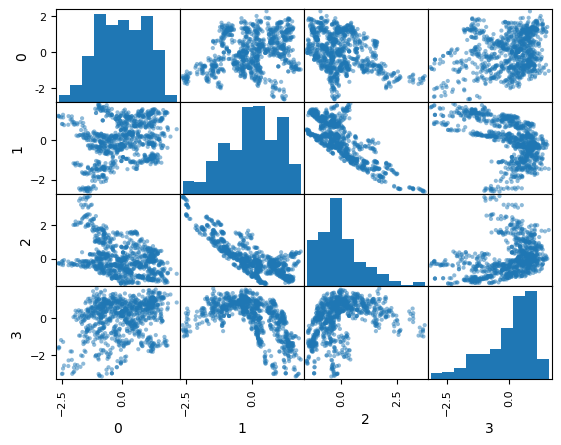

In [153]:
pd.plotting.scatter_matrix(pd.DataFrame(X_train))
plt.show()

In [138]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size=500,
    shuffle=True
)

In [139]:
model = LogisticRegression(num_features=4)
optimizer = torch.optim.SGD(model.parameters(), lr=.05)

n_epoch = 500

for epoch in range(n_epoch):
    
    model = model.train()
    for batch_idx, (features,class_labels) in enumerate(train_loader):
        prob = model(features)
        loss = F.binary_cross_entropy(prob, class_labels.view(prob.shape))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (batch_idx % 10 == 0) and (epoch % 5 == 0):
            print(f"Epoch: {epoch+1:03d}/{n_epoch:03d}"
            f" | Batch: {batch_idx+1:03d}/{len(train_loader):03d}"
            f" | Loss: {loss:.2f}")

Epoch: 001/500 | Batch: 001/002 | Loss: 0.76
Epoch: 006/500 | Batch: 001/002 | Loss: 0.32
Epoch: 011/500 | Batch: 001/002 | Loss: -0.00
Epoch: 016/500 | Batch: 001/002 | Loss: -0.28
Epoch: 021/500 | Batch: 001/002 | Loss: -0.60
Epoch: 026/500 | Batch: 001/002 | Loss: -0.82
Epoch: 031/500 | Batch: 001/002 | Loss: -0.94
Epoch: 036/500 | Batch: 001/002 | Loss: -1.15
Epoch: 041/500 | Batch: 001/002 | Loss: -1.22
Epoch: 046/500 | Batch: 001/002 | Loss: -1.44
Epoch: 051/500 | Batch: 001/002 | Loss: -1.56
Epoch: 056/500 | Batch: 001/002 | Loss: -1.66
Epoch: 061/500 | Batch: 001/002 | Loss: -1.93
Epoch: 066/500 | Batch: 001/002 | Loss: -2.25
Epoch: 071/500 | Batch: 001/002 | Loss: -2.28
Epoch: 076/500 | Batch: 001/002 | Loss: -2.57
Epoch: 081/500 | Batch: 001/002 | Loss: -2.65
Epoch: 086/500 | Batch: 001/002 | Loss: -2.72
Epoch: 091/500 | Batch: 001/002 | Loss: -2.96
Epoch: 096/500 | Batch: 001/002 | Loss: -3.07
Epoch: 101/500 | Batch: 001/002 | Loss: -3.07
Epoch: 106/500 | Batch: 001/002 | Lo

In [140]:
compute_accuracy(model, train_data)

tensor(0.8542)

In [141]:
compute_accuracy(model, test_data)

tensor(0.8252)